In [ ]:
# !pip install tensorflow keras tensorflow-addons protobuf --quiet
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
# extract_to = "/content/drive/MyDrive/Dataset/ "

# if not os.path.exists(extract_to):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_to)
#     print("✅ File berhasil diekstrak.")
# else:
#     print("⚠️ Folder sudah ada, skip ekstraksi.")

In [ ]:
import tensorflow as tf
import keras_tuner

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Import Libraries
import os
import shutil
import random
import gc
import json
from collections import Counter

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import regularizers

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# 2. Konfigurasi Variables
source_dataset_dir = '/content/drive/MyDrive/Dataset/Dataset'
initial_split_dir = '/content/drive/MyDrive/Dataset/initial_split1'
final_models_dir = '/content/drive/MyDrive/Dataset/final_models_resnet152B'
csv_fold_dir = '/content/drive/MyDrive/Dataset/cv_fold_results1'


IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
N_FOLDS = 5
N_CLASSES = 1

# # # Membersihkan direktori lama jika perlu
# if os.path.exists(initial_split_dir):
#     shutil.rmtree(initial_split_dir)
# if os.path.exists(final_models_dir):
#     shutil.rmtree(final_models_dir)
# os.makedirs(initial_split_dir, exist_ok=True)
# os.makedirs(csv_fold_dir, exist_ok=True)
# os.makedirs(final_models_dir, exist_ok=True)

In [ ]:
# Blok ini memastikan semua operasi acak (shuffling, inisialisasi bobot, dll.)
# akan menghasilkan output yang sama persis setiap kali kode dijalankan.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TFDETERMINISTICOPS'] = '1'
print(f"=== Seed ({SEED}) telah diatur untuk Reproducibility ===\n")

=== Seed (42) telah diatur untuk Reproducibility ===



In [ ]:
# 3. Pra-Pemrosesan Gambar
# 3.1. Split Data Awal (80% Train, 20% Test)
print("=== Memulai Split Data Awal (80% Train, 20% Test) ===")
train_full_dir = os.path.join(initial_split_dir, 'train')
test_final_dir = os.path.join(initial_split_dir, 'test')

# if os.path.exists(train_full_dir): shutil.rmtree(train_full_dir)
# if os.path.exists(test_final_dir): shutil.rmtree(test_final_dir)
# os.makedirs(train_full_dir, exist_ok=True)
# os.makedirs(test_final_dir, exist_ok=True)

# class_names_source = [d for d in os.listdir(source_dataset_dir) if os.path.isdir(os.path.join(source_dataset_dir, d))]

# for class_name in class_names_source:
#     class_path_source = os.path.join(source_dataset_dir, class_name)
#     os.makedirs(os.path.join(train_full_dir, class_name), exist_ok=True)
#     os.makedirs(os.path.join(test_final_dir, class_name), exist_ok=True)
#     images = [f for f in os.listdir(class_path_source) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
#     random.shuffle(images)
#     train_count = int(0.8 * len(images))
#     train_files = images[:train_count]
#     test_files = images[train_count:]
#     for img_name in train_files:
#         shutil.copy2(os.path.join(class_path_source, img_name), os.path.join(train_full_dir, class_name, img_name))
#     for img_name in test_files:
#         shutil.copy2(os.path.join(class_path_source, img_name), os.path.join(test_final_dir, class_name, img_name))
#     print(f"Kelas: {class_name} | Total: {len(images)} -> Train: {len(train_files)}, Test: {len(test_files)}")
# print("=== Split Data Awal Selesai ===\n")

=== Memulai Split Data Awal (80% Train, 20% Test) ===


In [ ]:
print("=== Mendefinisikan ImageDataGenerator ===")
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
print("ImageDataGenerator siap digunakan.\n")

=== Mendefinisikan ImageDataGenerator ===
ImageDataGenerator siap digunakan.



In [ ]:
# 4. Persiapan Data untuk 5-Fold Cross Validation
print("=== Mempersiapkan data untuk 5-Fold Cross Validation ===")
class_names_list = sorted([d for d in os.listdir(train_full_dir) if os.path.isdir(os.path.join(train_full_dir, d))])

filepaths = []
labels = []
for class_name in class_names_list:
    class_dir = os.path.join(train_full_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"Total gambar untuk CV: {len(df)}")
print(f"Distribusi kelas dalam data training:\n{df['label'].value_counts()}\n")

=== Mempersiapkan data untuk 5-Fold Cross Validation ===
Total gambar untuk CV: 2985
Distribusi kelas dalam data training:
label
Psoriasis    1644
Eczema       1341
Name: count, dtype: int64



In [ ]:
def build_resnet152_model(train_base=False):
    base_model = ResNet152(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False

    model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

    model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
    return model

# print("Model untuk Feature Extraction telah dibangun.")
# model.summary()

In [ ]:
# === 5-Fold Cross Validation - Feature Extraction (FE) ===
print("\n=== 5-Fold Cross Validation - Feature Extraction (FE) ===")
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
fe_fold_results = []
best_val_acc_fe = 0.0
best_fe_model_path = ""

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df['filepath'], df['label'])):
    print(f"\n--- Fold {fold_idx+1}/{N_FOLDS} - FE ---")
    gc.collect()

    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filepath', y_col='label', target_size=IMAGE_SIZE,
        class_mode='binary', batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filepath', y_col='label', target_size=IMAGE_SIZE,
        class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])))

    model = build_resnet152_model()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

    fe_model_path = os.path.join(final_models_dir, f'fe_model_fold_{fold_idx+1}.h5')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(fe_model_path, monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]

    history = model.fit(train_generator, validation_data=val_generator, epochs=50,
                        class_weight=class_weights, callbacks=callbacks, verbose=1)


    best_idx = np.argmax(history.history['val_accuracy'])
    train_acc = history.history['accuracy'][best_idx] * 100
    val_acc = history.history['val_accuracy'][best_idx] * 100

    if val_acc > best_val_acc_fe:
        best_val_acc_fe = val_acc
        best_fe_model_path = fe_model_path

    fe_fold_results.append({
        'Fold': f'Fold{fold_idx + 1}',
        'Train Acc (%)': round(train_acc, 2),
        'Train Loss': round(history.history['loss'][best_idx], 4),
        'Val Acc (%)': round(val_acc, 2),
        'Val Loss': round(history.history['val_loss'][best_idx], 4),
        'Gap (%)': round(train_acc - val_acc, 2)
    })

print("\n=== HASIL AKHIR CROSS VALIDATION - FEATURE EXTRACTION ===")
fe_df = pd.DataFrame(fe_fold_results)
fe_df.to_csv(os.path.join(csv_fold_dir, 'resnet152_fe_results.csv'), index=False)
print(fe_df.to_string(index=False))
print(f"\nRata-rata Val Acc: {fe_df['Val Acc (%)'].mean():.2f} (+/- {fe_df['Val Acc (%)'].std():.2f})")

if best_fe_model_path:
    shutil.copy2(best_fe_model_path, os.path.join(final_models_dir, 'best_fe_model.h5'))


=== 5-Fold Cross Validation - Feature Extraction (FE) ===

--- Fold 1/5 - FE ---
Found 2388 validated image filenames belonging to 2 classes.
Found 597 validated image filenames belonging to 2 classes.
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5623 - loss: 0.7719

299/299 ━━━━━━━━━━━━━━━━━━━━ 1085s 4s/step - accuracy: 0.5624 - loss: 0.7717 - val_accuracy: 0.6700 - val_loss: 0.6139 - learning_rate: 1.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 152ms/step - accuracy: 0.6882 - loss: 0.5959 - val_accuracy: 0.6549 - val_loss: 0.6263 - learning_rate: 1.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6953 - loss: 0.5725

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.6953 - loss: 0.5725 - val_accuracy: 0.7085 - val_loss: 0.5698 - learning_rate: 1.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7327 - loss: 0.5334

299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.7327 - loss: 0.5334 - val_accuracy: 0.7253 - val_loss: 0.5607 - learning_rate: 1.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.7342 - loss: 0.5457 - val_accuracy: 0.7186 - val_loss: 0.5641 - learning_rate: 1.0000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7585 - loss: 0.5015

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.7585 - loss: 0.5015 - val_accuracy: 0.7353 - val_loss: 0.5380 - learning_rate: 1.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.7476 - loss: 0.5090 - val_accuracy: 0.7219 - val_loss: 0.5567 - learning_rate: 1.0000e-04
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7570 - loss: 0.4784

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.7570 - loss: 0.4784 - val_accuracy: 0.7387 - val_loss: 0.5211 - learning_rate: 1.0000e-04
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7639 - loss: 0.4772 - val_accuracy: 0.7136 - val_loss: 0.5673 - learning_rate: 1.0000e-04
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.7835 - loss: 0.4640 - val_accuracy: 0.7337 - val_loss: 0.5441 - learning_rate: 1.0000e-04
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.7979 - loss: 0.4378 - val_accuracy: 0.7102 - val_loss: 0.5906 - learning_rate: 1.0000e-04
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8389 - loss: 0.3940

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.8388 - loss: 0.3941 - val_accuracy: 0.7454 - val_loss: 0.5327 - learning_rate: 2.0000e-05
Epoch 13/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.8071 - loss: 0.4110 - val_accuracy: 0.7420 - val_loss: 0.5418 - learning_rate: 2.0000e-05

--- Fold 2/5 - FE ---
Found 2388 validated image filenames belonging to 2 classes.
Found 597 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5755 - loss: 0.7293

299/299 ━━━━━━━━━━━━━━━━━━━━ 88s 212ms/step - accuracy: 0.5755 - loss: 0.7292 - val_accuracy: 0.6633 - val_loss: 0.6306 - learning_rate: 1.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step - accuracy: 0.6637 - loss: 0.6060 - val_accuracy: 0.6633 - val_loss: 0.6176 - learning_rate: 1.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6731 - loss: 0.5809

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.6732 - loss: 0.5808 - val_accuracy: 0.6784 - val_loss: 0.6035 - learning_rate: 1.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7127 - loss: 0.5433 - val_accuracy: 0.6583 - val_loss: 0.6268 - learning_rate: 1.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7359 - loss: 0.5252

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.7359 - loss: 0.5252 - val_accuracy: 0.6817 - val_loss: 0.5837 - learning_rate: 1.0000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.7447 - loss: 0.5200 - val_accuracy: 0.6700 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7451 - loss: 0.5050

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.7452 - loss: 0.5049 - val_accuracy: 0.6951 - val_loss: 0.5766 - learning_rate: 1.0000e-04
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.7831 - loss: 0.4703 - val_accuracy: 0.6650 - val_loss: 0.6028 - learning_rate: 1.0000e-04
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.7677 - loss: 0.4689 - val_accuracy: 0.6834 - val_loss: 0.5927 - learning_rate: 1.0000e-04
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7946 - loss: 0.4338

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.7946 - loss: 0.4339 - val_accuracy: 0.7102 - val_loss: 0.5466 - learning_rate: 1.0000e-04
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.7833 - loss: 0.4434 - val_accuracy: 0.6935 - val_loss: 0.5606 - learning_rate: 1.0000e-04
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8095 - loss: 0.4242

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8095 - loss: 0.4243 - val_accuracy: 0.7152 - val_loss: 0.5368 - learning_rate: 1.0000e-04
Epoch 13/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.7957 - loss: 0.4222 - val_accuracy: 0.7136 - val_loss: 0.5432 - learning_rate: 1.0000e-04
Epoch 14/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8163 - loss: 0.4068

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.8164 - loss: 0.4068 - val_accuracy: 0.7203 - val_loss: 0.5379 - learning_rate: 1.0000e-04
Epoch 15/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8292 - loss: 0.3897

299/299 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.8292 - loss: 0.3897 - val_accuracy: 0.7303 - val_loss: 0.5347 - learning_rate: 1.0000e-04
Epoch 16/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.8340 - loss: 0.3736 - val_accuracy: 0.7236 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 17/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.8354 - loss: 0.3756 - val_accuracy: 0.7303 - val_loss: 0.5365 - learning_rate: 1.0000e-04
Epoch 18/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8234 - loss: 0.3991 - val_accuracy: 0.7253 - val_loss: 0.5328 - learning_rate: 1.0000e-04
Epoch 19/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8451 - loss: 0.3503 - val_accuracy: 0.7253 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 20/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.8490 - loss: 0.3520 - val_accuracy: 0.7119 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 21/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5990 - loss: 0.7392

299/299 ━━━━━━━━━━━━━━━━━━━━ 89s 217ms/step - accuracy: 0.5991 - loss: 0.7391 - val_accuracy: 0.6449 - val_loss: 0.6525 - learning_rate: 1.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6481 - loss: 0.6339

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.6481 - loss: 0.6339 - val_accuracy: 0.6834 - val_loss: 0.5919 - learning_rate: 1.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6987 - loss: 0.5728

299/299 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.6987 - loss: 0.5728 - val_accuracy: 0.7052 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 155ms/step - accuracy: 0.7116 - loss: 0.5512 - val_accuracy: 0.7002 - val_loss: 0.5873 - learning_rate: 1.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7411 - loss: 0.5394

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.7411 - loss: 0.5394 - val_accuracy: 0.7102 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7313 - loss: 0.5208

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.7313 - loss: 0.5208 - val_accuracy: 0.7320 - val_loss: 0.5228 - learning_rate: 1.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7520 - loss: 0.4964

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.7521 - loss: 0.4964 - val_accuracy: 0.7420 - val_loss: 0.5112 - learning_rate: 1.0000e-04
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.7563 - loss: 0.5090 - val_accuracy: 0.7186 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.7683 - loss: 0.4708 - val_accuracy: 0.7119 - val_loss: 0.5445 - learning_rate: 1.0000e-04
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7857 - loss: 0.4651

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.7857 - loss: 0.4651 - val_accuracy: 0.7471 - val_loss: 0.4962 - learning_rate: 1.0000e-04
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 155ms/step - accuracy: 0.8027 - loss: 0.4323 - val_accuracy: 0.7437 - val_loss: 0.5066 - learning_rate: 1.0000e-04
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - accuracy: 0.8177 - loss: 0.4303 - val_accuracy: 0.7320 - val_loss: 0.5065 - learning_rate: 1.0000e-04
Epoch 13/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8088 - loss: 0.4199

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.8088 - loss: 0.4199 - val_accuracy: 0.7588 - val_loss: 0.4840 - learning_rate: 1.0000e-04
Epoch 14/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.8137 - loss: 0.4150 - val_accuracy: 0.7521 - val_loss: 0.4943 - learning_rate: 1.0000e-04
Epoch 15/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8355 - loss: 0.3713

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.8354 - loss: 0.3714 - val_accuracy: 0.7672 - val_loss: 0.4615 - learning_rate: 1.0000e-04
Epoch 16/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.8099 - loss: 0.4065 - val_accuracy: 0.7605 - val_loss: 0.4728 - learning_rate: 1.0000e-04
Epoch 17/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8288 - loss: 0.3862 - val_accuracy: 0.7521 - val_loss: 0.4982 - learning_rate: 1.0000e-04
Epoch 18/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8386 - loss: 0.3768

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.8385 - loss: 0.3768 - val_accuracy: 0.7739 - val_loss: 0.4710 - learning_rate: 1.0000e-04
Epoch 19/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8298 - loss: 0.3943

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8299 - loss: 0.3942 - val_accuracy: 0.7822 - val_loss: 0.4626 - learning_rate: 2.0000e-05
Epoch 20/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.8540 - loss: 0.3549 - val_accuracy: 0.7722 - val_loss: 0.4622 - learning_rate: 2.0000e-05

--- Fold 4/5 - FE ---
Found 2388 validated image filenames belonging to 2 classes.
Found 597 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5688 - loss: 0.7491

299/299 ━━━━━━━━━━━━━━━━━━━━ 89s 215ms/step - accuracy: 0.5689 - loss: 0.7489 - val_accuracy: 0.6868 - val_loss: 0.5910 - learning_rate: 1.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6449 - loss: 0.6284

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - accuracy: 0.6450 - loss: 0.6284 - val_accuracy: 0.7052 - val_loss: 0.5604 - learning_rate: 1.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6913 - loss: 0.5729

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.6913 - loss: 0.5729 - val_accuracy: 0.7186 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6977 - loss: 0.5704

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.6977 - loss: 0.5704 - val_accuracy: 0.7353 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.7296 - loss: 0.5394 - val_accuracy: 0.7119 - val_loss: 0.5436 - learning_rate: 1.0000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7427 - loss: 0.5141

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.7427 - loss: 0.5141 - val_accuracy: 0.7471 - val_loss: 0.5316 - learning_rate: 1.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7478 - loss: 0.4995

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.7478 - loss: 0.4995 - val_accuracy: 0.7571 - val_loss: 0.5021 - learning_rate: 1.0000e-04
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7673 - loss: 0.4904 - val_accuracy: 0.7370 - val_loss: 0.5238 - learning_rate: 1.0000e-04
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7899 - loss: 0.4580

299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.7898 - loss: 0.4580 - val_accuracy: 0.7705 - val_loss: 0.5114 - learning_rate: 1.0000e-04
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7651 - loss: 0.4681

299/299 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.7651 - loss: 0.4681 - val_accuracy: 0.7956 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 155ms/step - accuracy: 0.7973 - loss: 0.4379 - val_accuracy: 0.7672 - val_loss: 0.4961 - learning_rate: 1.0000e-04
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.8121 - loss: 0.4242 - val_accuracy: 0.7521 - val_loss: 0.5273 - learning_rate: 1.0000e-04
Epoch 13/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8078 - loss: 0.4215 - val_accuracy: 0.7370 - val_loss: 0.5329 - learning_rate: 1.0000e-04
Epoch 14/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8144 - loss: 0.3972 - val_accuracy: 0.7688 - val_loss: 0.5044 - learning_rate: 2.0000e-05
Epoch 15/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.8251 - loss: 0.4004 - val_accuracy: 0.7839 - val_loss: 0.4798 - learning_rate: 2.0000e-05
Epoch 16/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 43s 145ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5727 - loss: 0.7830

299/299 ━━━━━━━━━━━━━━━━━━━━ 87s 212ms/step - accuracy: 0.5728 - loss: 0.7828 - val_accuracy: 0.6784 - val_loss: 0.6080 - learning_rate: 1.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6466 - loss: 0.6334

299/299 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.6466 - loss: 0.6334 - val_accuracy: 0.7236 - val_loss: 0.5705 - learning_rate: 1.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7238 - loss: 0.5610

299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.7237 - loss: 0.5610 - val_accuracy: 0.7404 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.6958 - loss: 0.5737 - val_accuracy: 0.7320 - val_loss: 0.5401 - learning_rate: 1.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.7388 - loss: 0.5234 - val_accuracy: 0.6834 - val_loss: 0.5725 - learning_rate: 1.0000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.7241 - loss: 0.5257 - val_accuracy: 0.7370 - val_loss: 0.5194 - learning_rate: 1.0000e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7455 - loss: 0.5006

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.7456 - loss: 0.5006 - val_accuracy: 0.7487 - val_loss: 0.5158 - learning_rate: 1.0000e-04
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.7796 - loss: 0.4703 - val_accuracy: 0.7454 - val_loss: 0.5102 - learning_rate: 1.0000e-04
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 151ms/step - accuracy: 0.7867 - loss: 0.4634 - val_accuracy: 0.7303 - val_loss: 0.5393 - learning_rate: 1.0000e-04
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7795 - loss: 0.4692

299/299 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.7795 - loss: 0.4692 - val_accuracy: 0.7655 - val_loss: 0.5079 - learning_rate: 1.0000e-04
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.7790 - loss: 0.4511 - val_accuracy: 0.7487 - val_loss: 0.5146 - learning_rate: 1.0000e-04
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.7959 - loss: 0.4300 - val_accuracy: 0.7621 - val_loss: 0.4864 - learning_rate: 1.0000e-04
Epoch 13/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.7994 - loss: 0.4332 - val_accuracy: 0.7487 - val_loss: 0.5250 - learning_rate: 1.0000e-04
Epoch 14/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8104 - loss: 0.4212 - val_accuracy: 0.7236 - val_loss: 0.5409 - learning_rate: 1.0000e-04
Epoch 15/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8161 - loss: 0.4028

299/299 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8161 - loss: 0.4028 - val_accuracy: 0.7688 - val_loss: 0.4933 - learning_rate: 1.0000e-04
Epoch 16/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - accuracy: 0.8282 - loss: 0.3766 - val_accuracy: 0.7605 - val_loss: 0.4876 - learning_rate: 2.0000e-05
Epoch 17/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.8332 - loss: 0.3831 - val_accuracy: 0.7571 - val_loss: 0.4940 - learning_rate: 2.0000e-05

=== HASIL AKHIR CROSS VALIDATION - FEATURE EXTRACTION ===
 Fold  Train Acc (%)  Train Loss  Val Acc (%)  Val Loss  Gap (%)
Fold1          81.70      0.4135        74.54    0.5327     7.16
Fold2          82.24      0.3983        73.03    0.5347     9.21
Fold3          83.79      0.3737        78.22    0.4626     5.57
Fold4          76.76      0.4631        79.56    0.4799    -2.81
Fold5          81.11      0.4099        76.88    0.4933     4.23

Rata-rata Val Acc: 76.45 (+/- 2.66)


In [ ]:
print("\n=== Fine-Tuning Final Model Berdasarkan best_fe_model.h5 ===")
gc.collect()

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label', target_size=IMAGE_SIZE,
    class_mode='binary', batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label', target_size=IMAGE_SIZE,
    class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])))

model = load_model(os.path.join(final_models_dir, 'best_fe_model.h5'))

base_model = model.layers[0]
base_model.trainable = True
fine_tune_from = 'conv5_block1_1_conv'
fine_tune_at_index = None
for i, layer in enumerate(base_model.layers):
    if layer.name == fine_tune_from:
        fine_tune_at_index = i
        break

if fine_tune_at_index is None:
    raise ValueError(f"Layer '{fine_tune_from}' tidak ditemukan dalam model.")

for layer in base_model.layers[:fine_tune_at_index]:
    layer.trainable = False

print(f"\nFine-tuning dimulai dari layer '{fine_tune_from}' (index: {fine_tune_at_index})")

model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='binary_crossentropy', metrics=['accuracy'])

ft_model_path = os.path.join(final_models_dir, 'best_ft_model.h5')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(ft_model_path, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50,
                    class_weight=class_weights,
                    callbacks=callbacks,
                    verbose=1)

best_idx = np.argmax(history.history['val_accuracy'])
train_acc = history.history['accuracy'][best_idx] * 100
val_acc = history.history['val_accuracy'][best_idx] * 100

ft_result = {
    'Train Acc (%)': round(train_acc, 2),
    'Train Loss': round(history.history['loss'][best_idx], 4),
    'Val Acc (%)': round(val_acc, 2),
    'Val Loss': round(history.history['val_loss'][best_idx], 4),
    'Gap (%)': round(train_acc - val_acc, 2)
}

ft_df = pd.DataFrame([ft_result])
ft_df.to_csv(os.path.join(csv_fold_dir, 'resnet152_ft_final.csv'), index=False)

print("\n=== HASIL FINE-TUNING FINAL MODEL ===")
print(ft_df.to_string(index=False))

shutil.copy2(ft_model_path, os.path.join(final_models_dir, 'best_final_model.h5'))



=== Fine-Tuning Final Model Berdasarkan best_fe_model.h5 ===
Found 2388 validated image filenames belonging to 2 classes.
Found 597 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Fine-tuning dimulai dari layer 'conv5_block1_1_conv' (index: 483)
Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6972 - loss: 0.5687

299/299 ━━━━━━━━━━━━━━━━━━━━ 98s 229ms/step - accuracy: 0.6972 - loss: 0.5686 - val_accuracy: 0.7454 - val_loss: 0.4880 - learning_rate: 1.0000e-05
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7635 - loss: 0.4873

299/299 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step - accuracy: 0.7635 - loss: 0.4873 - val_accuracy: 0.7588 - val_loss: 0.4891 - learning_rate: 1.0000e-05
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7798 - loss: 0.4537

299/299 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.7798 - loss: 0.4537 - val_accuracy: 0.7739 - val_loss: 0.4830 - learning_rate: 1.0000e-05
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7938 - loss: 0.4462

299/299 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - accuracy: 0.7938 - loss: 0.4462 - val_accuracy: 0.7856 - val_loss: 0.4497 - learning_rate: 1.0000e-05
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8134 - loss: 0.4189

299/299 ━━━━━━━━━━━━━━━━━━━━ 59s 198ms/step - accuracy: 0.8134 - loss: 0.4189 - val_accuracy: 0.7940 - val_loss: 0.4521 - learning_rate: 1.0000e-05
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8250 - loss: 0.3842

299/299 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - accuracy: 0.8250 - loss: 0.3842 - val_accuracy: 0.8007 - val_loss: 0.4364 - learning_rate: 1.0000e-05
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8326 - loss: 0.3815

299/299 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.8326 - loss: 0.3815 - val_accuracy: 0.8057 - val_loss: 0.4161 - learning_rate: 1.0000e-05
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.8595 - loss: 0.3466 - val_accuracy: 0.7956 - val_loss: 0.4388 - learning_rate: 1.0000e-05
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8644 - loss: 0.3314 - val_accuracy: 0.8040 - val_loss: 0.4432 - learning_rate: 1.0000e-05
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8743 - loss: 0.3205

299/299 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.8743 - loss: 0.3205 - val_accuracy: 0.8208 - val_loss: 0.4317 - learning_rate: 1.0000e-05
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.8940 - loss: 0.2789 - val_accuracy: 0.8023 - val_loss: 0.4433 - learning_rate: 2.0000e-06
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - accuracy: 0.8758 - loss: 0.2920 - val_accuracy: 0.8107 - val_loss: 0.4472 - learning_rate: 2.0000e-06

=== HASIL FINE-TUNING FINAL MODEL ===
 Train Acc (%)  Train Loss  Val Acc (%)  Val Loss  Gap (%)
         86.93      0.3184        82.08    0.4317     4.86


'/content/drive/MyDrive/Dataset/final_models_resnet152B/best_final_model.h5'

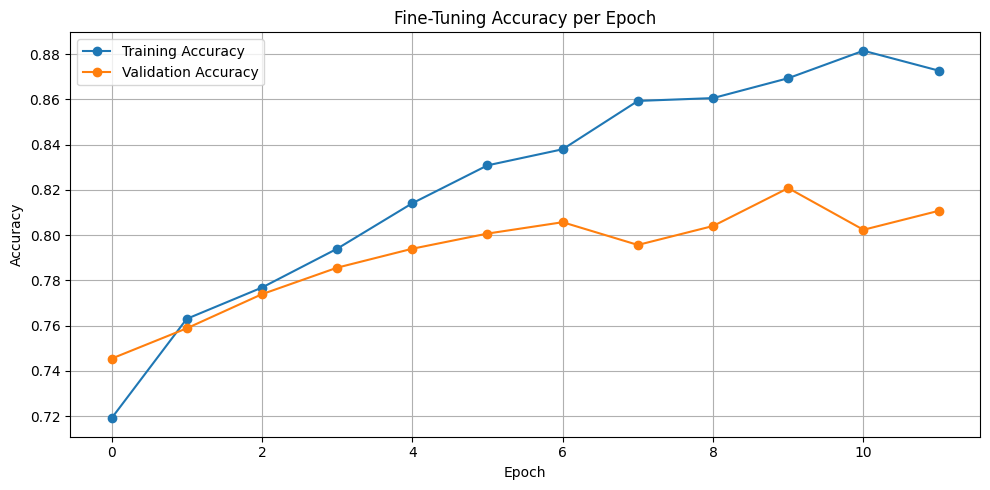

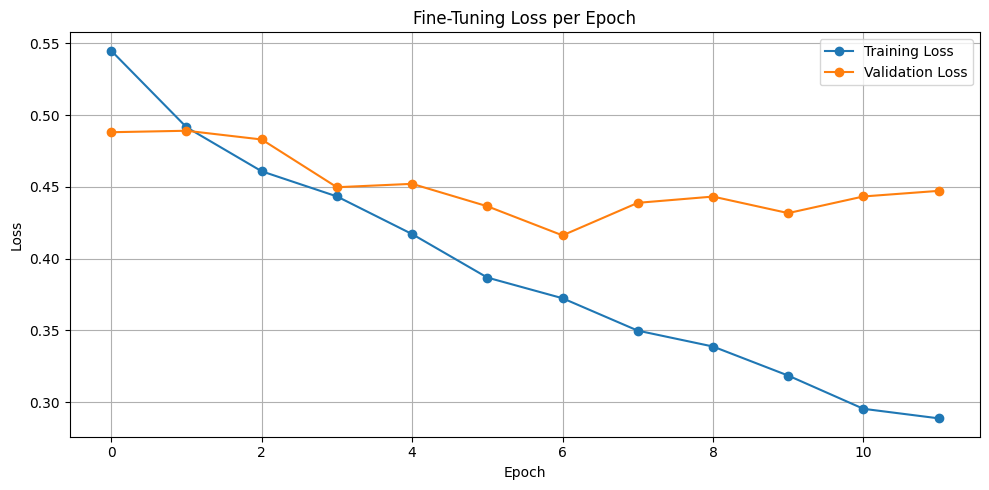

In [ ]:
import matplotlib.pyplot as plt

# === Plot Accuracy Curve ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Fine-Tuning Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(csv_fold_dir, 'fine_tuning_accuracy_curve.png'))
plt.show()

# === Plot Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Fine-Tuning Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(csv_fold_dir, 'fine_tuning_loss_curve.png'))
plt.show()



=== Evaluasi Model Final di Test Set ===
Total gambar di test set: 747
label
Psoriasis    411
Eczema       336
Name: count, dtype: int64


Found 747 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
              precision    recall  f1-score   support

      Eczema       0.76      0.83      0.79       336
   Psoriasis       0.85      0.79      0.82       411

    accuracy                           0.81       747
   macro avg       0.80      0.81      0.81       747
weighted avg       0.81      0.81      0.81       747



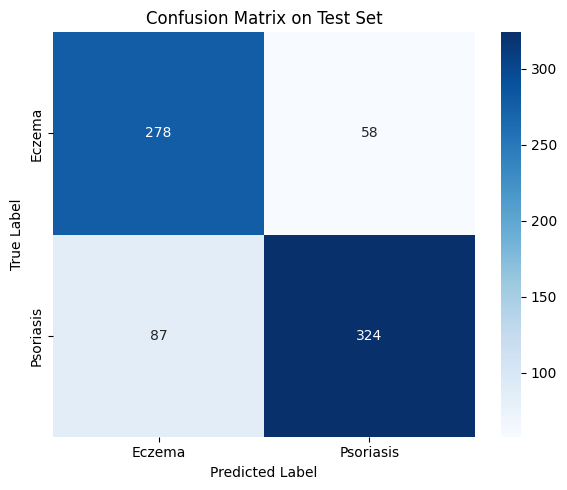

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("\n=== Evaluasi Model Final di Test Set ===")
gc.collect()

test_final_dir = os.path.join(initial_split_dir, 'test')

test_filepaths = []
test_labels = []

for class_name in os.listdir(test_final_dir):
    class_path = os.path.join(test_final_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_filepaths.append(os.path.join(class_path, fname))
                test_labels.append(class_name)

test_df = pd.DataFrame({
    'filepath': test_filepaths,
    'label': test_labels
})

print(f"Total gambar di test set: {len(test_df)}")
print(test_df['label'].value_counts())

final_model = load_model(os.path.join(final_models_dir, 'best_final_model.h5'))

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

y_true = test_generator.classes
y_pred_prob = final_model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names, digits=2))

report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names, output_dict=True)).transpose()
report_df.to_csv(os.path.join(csv_fold_dir, 'resnet152_test_evaluation.csv'), index=True)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(csv_fold_dir, 'confusion_matrix_test.png'))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Path gambar     : /content/drive/MyDrive/Dataset/test_sample/0_28.jpg
Hasil prediksi  : Eczema
Probabilitas    : 0.2072


/tmp/ipython-input-19-1968608388.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_class = int(prediction[0] > 0.5)  # Threshold 0.5


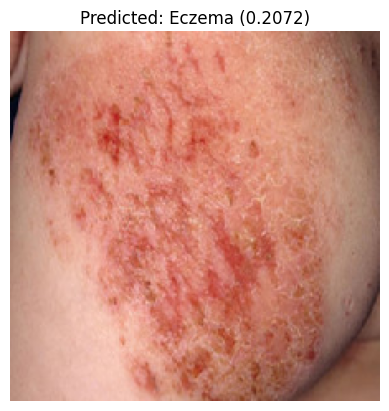

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Path gambar uji
img_path = '/content/drive/MyDrive/Dataset/test_sample/0_28.jpg'  # GANTI dengan path gambar kamu

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)  # Gunakan ResNet152 preprocessing
img_array = np.expand_dims(img_array, axis=0)  # Ubah ke shape (1, H, W, 3)

# Prediksi
prediction = final_model.predict(img_array)
pred_class = int(prediction[0] > 0.5)  # Threshold 0.5
class_names = list(test_generator.class_indices.keys())  # Ambil nama kelas dari generator
pred_label = class_names[pred_class]

# Tampilkan hasil
print(f"\nPath gambar     : {img_path}")
print(f"Hasil prediksi  : {pred_label}")
print(f"Probabilitas    : {prediction[0][0]:.4f}")

# Visualisasi gambar
plt.imshow(img)
plt.title(f"Predicted: {pred_label} ({prediction[0][0]:.4f})")
plt.axis('off')
plt.show()


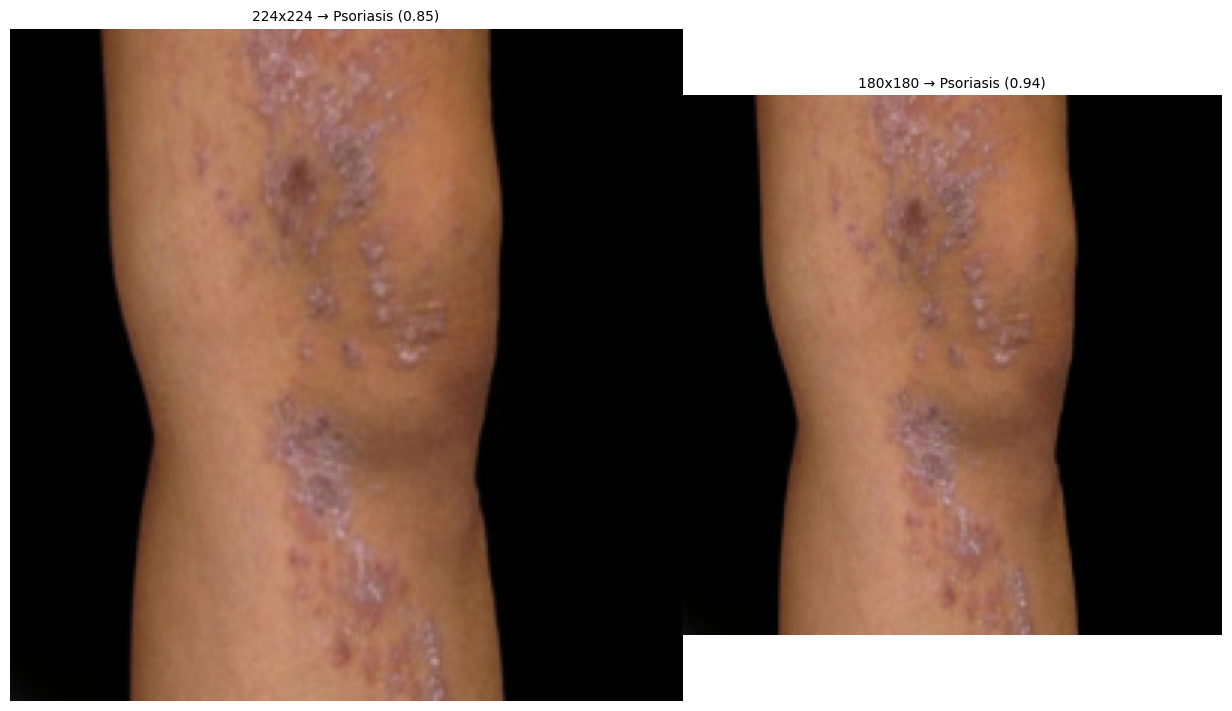

[0_51.jpg] 224x224 → Psoriasis | 180x180 → Psoriasis
Saved to: /content/drive/MyDrive/Dataset/Output/real_size_0_51.jpg



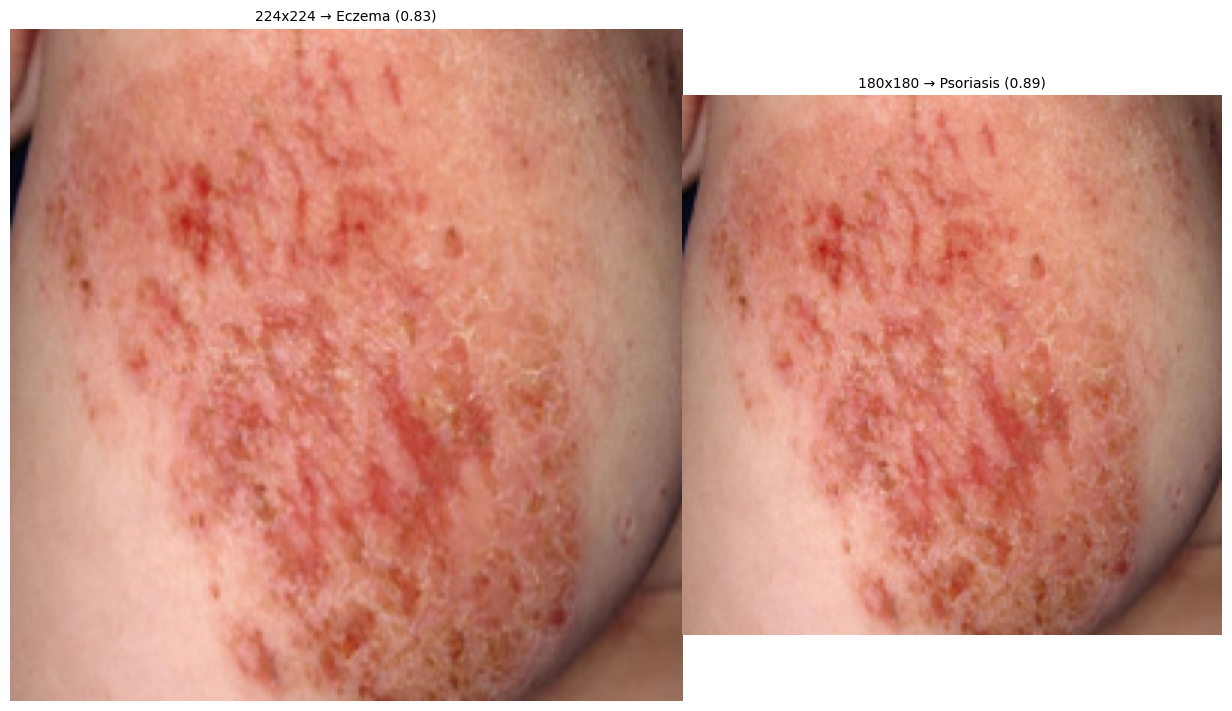

[0_28.jpg] 224x224 → Eczema | 180x180 → Psoriasis
Saved to: /content/drive/MyDrive/Dataset/Output/real_size_0_28.jpg



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model

# Load model
model = load_model(os.path.join(final_models_dir, 'best_final_model.h5'))

# Path gambar
test_folder = '/content/drive/MyDrive/Dataset/test_sample/'
output_dir = '/content/drive/MyDrive/Dataset/Output/'
os.makedirs(output_dir, exist_ok=True)

def predict_and_preprocess(img_path, resize_shape):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, resize_shape)

    x = img_to_array(resized)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    pred = model.predict(x, verbose=0)[0][0]
    label = 'Psoriasis' if pred >= 0.5 else 'Eczema'
    prob = float(pred) if pred >= 0.5 else 1 - float(pred)

    return resized, label, prob

# Skala per pixel untuk figsize (misalnya 1 pixel = 0.03 inch)
scale = 0.03

for fname in os.listdir(test_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_folder, fname)

        img_224, label_224, prob_224 = predict_and_preprocess(img_path, (224, 224))
        img_180, label_180, prob_180 = predict_and_preprocess(img_path, (180, 180))

        # Konversi ukuran pixel ke ukuran figure (dalam inch)
        width_total = img_224.shape[1] + img_180.shape[1]
        height_max = max(img_224.shape[0], img_180.shape[0])
        fig_width = width_total * scale
        fig_height = height_max * scale

        # Plot gambar dengan ukuran real relatif
        fig = plt.figure(figsize=(fig_width, fig_height))
        ax1 = fig.add_axes([0.0, 0, img_224.shape[1]/width_total, 1])
        ax1.imshow(img_224)
        ax1.set_title(f"224x224 → {label_224} ({prob_224:.2f})", fontsize=10)
        ax1.axis('off')

        ax2 = fig.add_axes([img_224.shape[1]/width_total, 0, img_180.shape[1]/width_total, 1])
        ax2.imshow(img_180)
        ax2.set_title(f"180x180 → {label_180} ({prob_180:.2f})", fontsize=10)
        ax2.axis('off')

        # Simpan hasil
        output_path = os.path.join(output_dir, f"real_size_{fname}")
        plt.savefig(output_path, dpi=150)
        plt.show()

        print(f"[{fname}] 224x224 → {label_224} | 180x180 → {label_180}")
        print(f"Saved to: {output_path}\n")


/tmp/ipython-input-19-3795444713.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


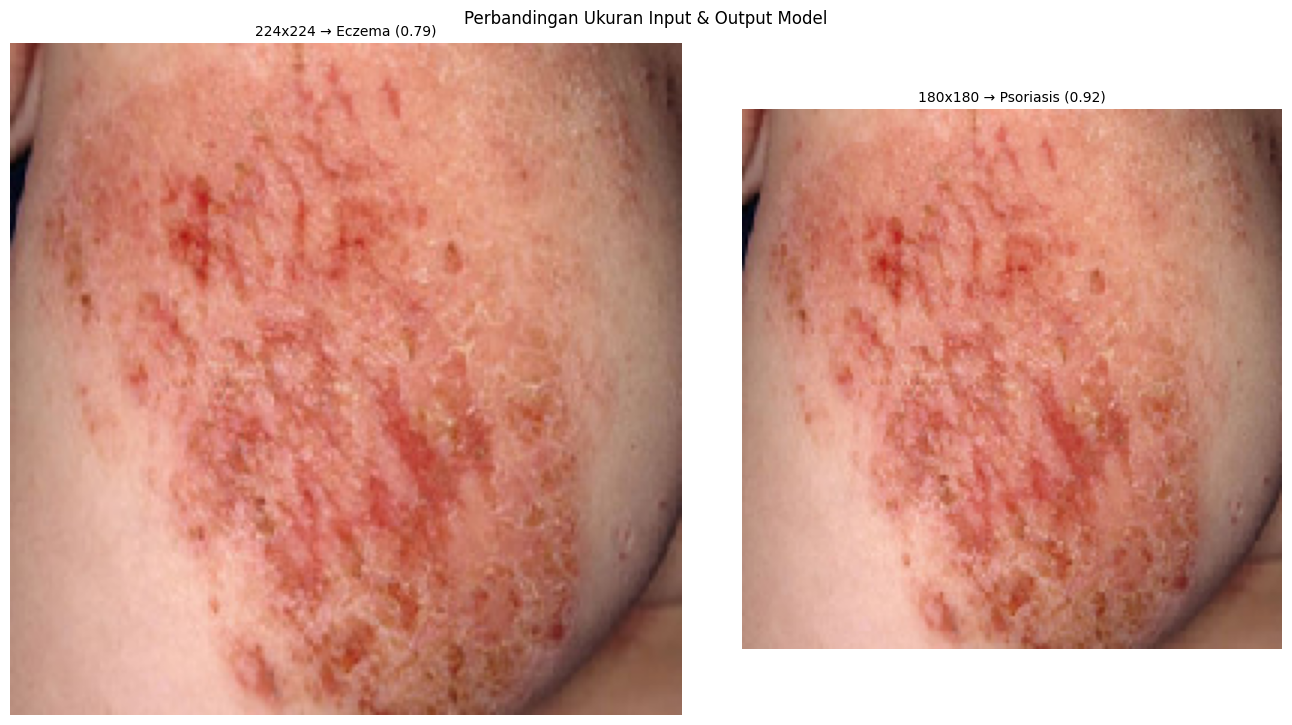

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_for_resolution(img_path, model, target_size, class_names):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)[0][0]
    pred_class = int(pred > 0.5)
    pred_label = class_names[pred_class]
    prob = pred if pred_class == 1 else 1 - pred

    return image.img_to_array(img).astype(np.uint8), pred_label, prob

# === Konfigurasi ===
img_path = '/content/drive/MyDrive/Dataset/test_sample/0_28.jpg'
resolutions = [(224, 224), (180, 180)]
gap_px = 20  # jarak horizontal antar gambar dalam pixel
class_names = list(test_generator.class_indices.keys())  # atau ['Eczema', 'Psoriasis']

results = []
for res in resolutions:
    img_arr, label, prob = predict_for_resolution(img_path, final_model, res, class_names)
    results.append((res, img_arr, label, prob))

# Hitung ukuran gambar akhir dengan jarak
scale = 0.03  # pixel ke inch
total_width = sum([r[0][0] for r in results]) + (len(results)-1)*gap_px
max_height = max([r[0][1] for r in results])

fig_width = total_width * scale
fig_height = max_height * scale

# Plot dengan jarak antar gambar
fig = plt.figure(figsize=(fig_width, fig_height))

x_offset = 0
for i, (res, img, label, prob) in enumerate(results):
    w, h = res
    ax = fig.add_axes([x_offset / total_width, 0, w / total_width, 1])
    ax.imshow(img.astype(np.uint8) / 255.)
    ax.set_title(f"{w}x{h} → {label} ({prob:.2f})", fontsize=10)
    ax.axis('off')
    x_offset += w + gap_px

plt.suptitle("Perbandingan Ukuran Input & Output Model", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()
